# 0.0 Imports

### 0.1 Helper Libs

In [86]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from matplotlib import gridspec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

### 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

pd.options.display.max_columns = None

# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

### 1.1 Renaming Columns

In [4]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [6]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [7]:
print( 'Number of Rows {}'.format(df1.shape[0]))
print( 'Number of Columns {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Columns 18


### 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### 1.4 Checking Null Values

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fill Out NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x) 
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

### 1.6 Fix Datatypes

In [11]:
df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
df1.competition_open_since_year = df1.competition_open_since_year.astype(int)
df1.promo2_since_week = df1.promo2_since_week.astype(int)
df1.promo2_since_year = df1.promo2_since_year.astype(int)

### 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [13]:
#Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["Attribute", "Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
m

,Attribute,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

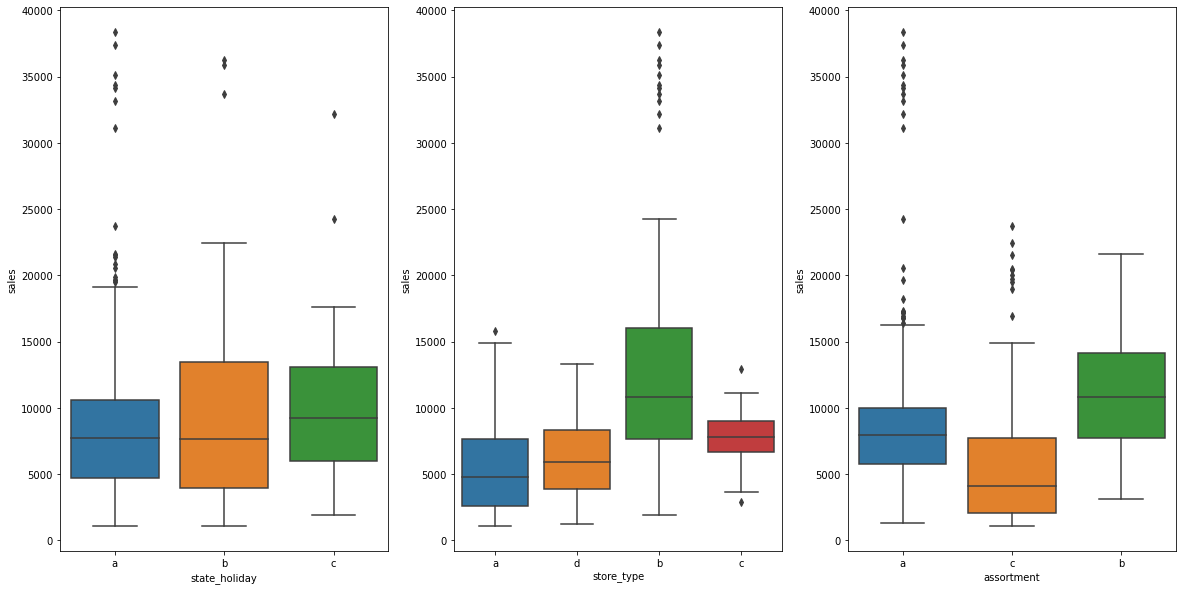

In [15]:
plt.rcParams['figure.figsize'] = (20, 10)
aux1 = df1[(df1['state_holiday'] != '0') & df1['sales'] > 0]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

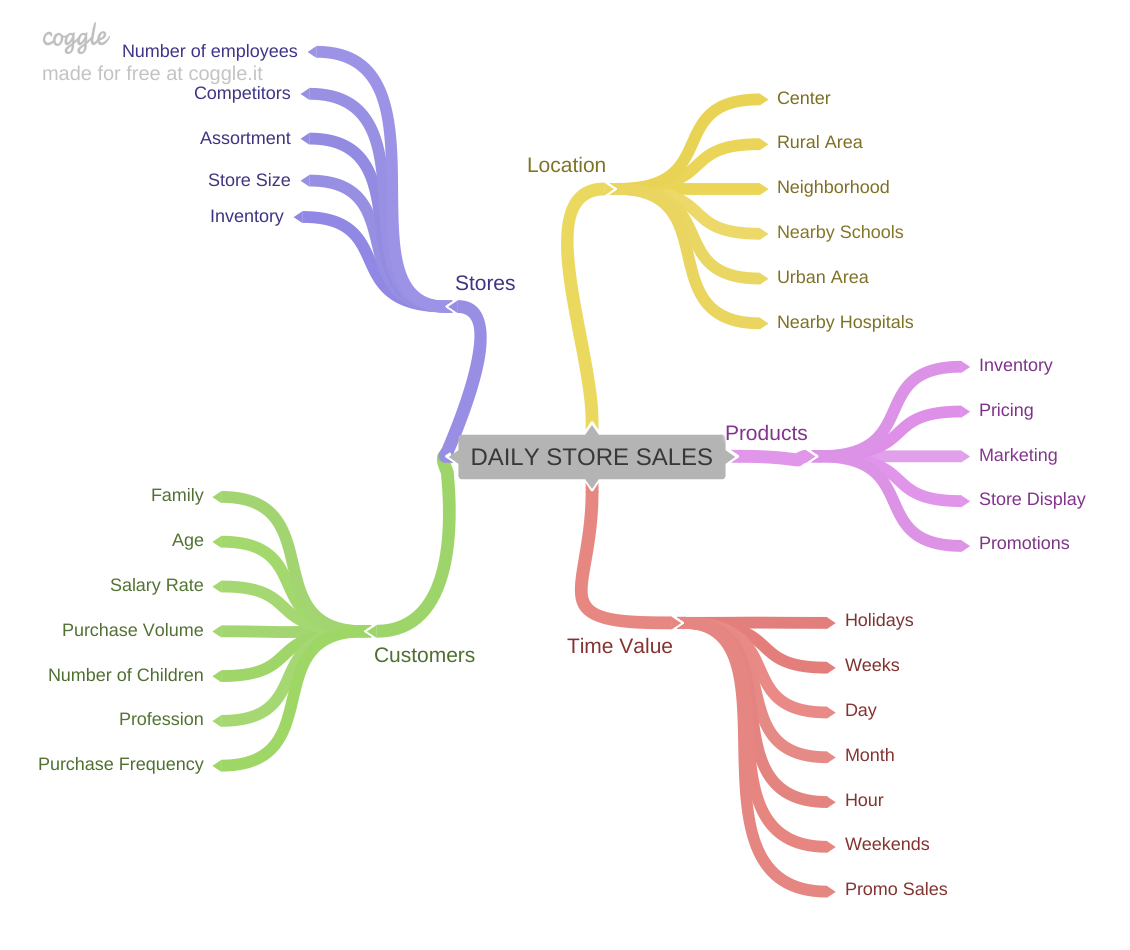

In [17]:
Image("img/MindMapHypothesis.png", width=500, height=500)

## 2.1 Hypothesis

### 2.1.1 Store Hypothesis

**1-** Stores with more employees should sell more.

**2-** Stores with more invenory should sell more.

**3-** More Sized stores should sell more.

**4-** Less Sized stores should sell less.

**5-** Stores with a broader product assortment should sell more.

**6-** Stores with a closer competition should sell less.

**7-** Stores with a closer competition for longer should sell less.


### 2.1.2 Product Hypothesis

**1-** Stores with more marketing spendings should sell more.

**2-** Stores more displayed products should sell more.

**3-** Stores with attractive pricing should sell more.

**4-** Stores with longer attractive pricing should sell more.

**5-** Stores with aggressive sales campaigns should sell more.

**6-** Stores with longer aggressive sales campaigns should sell more.

**7-** Stores with higher number of sales campaigns should sell more.

**8-** Stores with consecutive sales campaigns should sell more.

### 2.1.3 Time Hypothesis

**1-** Stores open during christmas holidays should have more sales.

**2-** Stores should sell more along the years.

**3-** Stores should sell more on the second semester of years.

**4-** Stores should sell more after the 10th of each month.

**5-** Stores should sell less on weekends.

**6-** Stores should sell less during scholar holidays


## 2.2 Final Hypothesis List

**1-** Stores with a broader product assortment should sell more.

**2-** Stores with a closer competition should sell less.

**3-** Stores with a closer competition for longer should sell more.

**4-** Stores with longer active sales campaigns should sell more.

**5-** Stores with higher number of sales campaigns should sell more.

**6-** Stores with consecutive sales campaigns should sell more.

**7-** Stores open during christmas holidays should have more sales.

**8-** Stores should sell more along the years.

**9-** Stores should sell more on the second semester of years.

**10-** Stores should sell more after the 10th of each month.

**11-** Stores should sell less on weekends.

**12-** Stores should sell less during scholar holidays

## 2.3 Feature Engineering

In [18]:
df2.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [19]:
#year
df2['Year'] = df2['date'].dt.year

#month
df2['Month'] = df2['date'].dt.month

#day
df2['Day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'],month= x['competition_open_since_month'],day= 1), axis= 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c' else 'regular_day')

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


# 3.0 Variables Filtering

In [20]:
df3 = df2.copy()
df3

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,Year,Month,Day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,basic,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,extended,1880.0,4,2006,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,9260.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,870.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


### 3.1 Rows Filtering

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Columns Selection

In [22]:
cols_drop = ['customers', 'promo_interval', 'open', 'month_map']
df3.drop(cols_drop, axis = 1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,Year,Month,Day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


In [23]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'Year',
       'Month', 'Day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Data Exploratory Analysis

In [24]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Response Variable

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

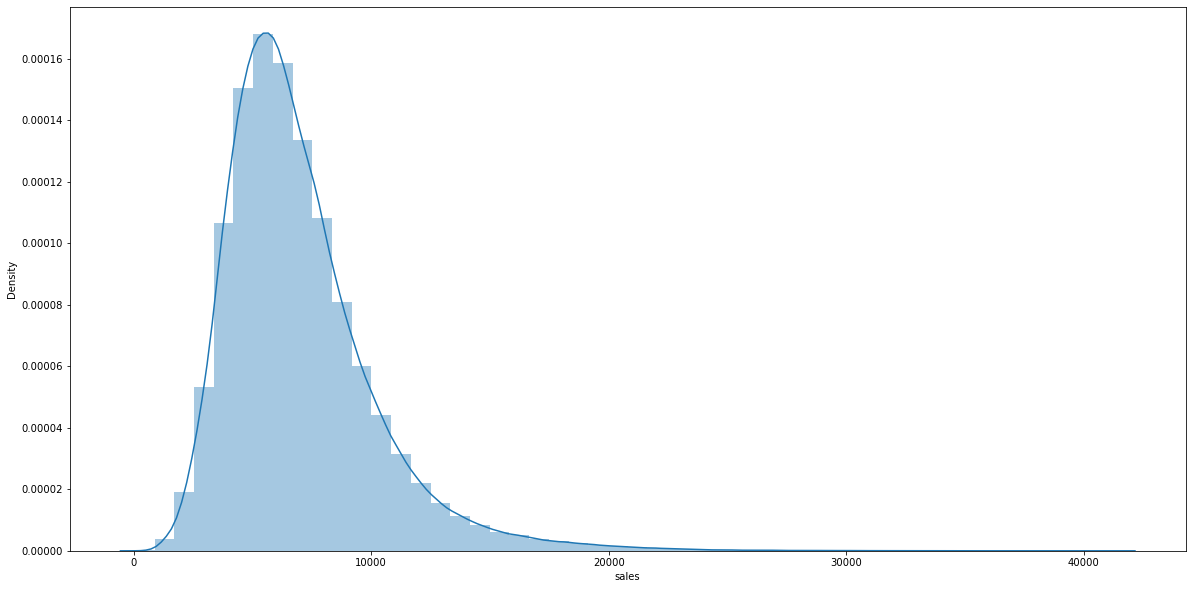

In [25]:
sns.distplot(df4['sales'])

#### 4.1.2 Numerical Variable

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


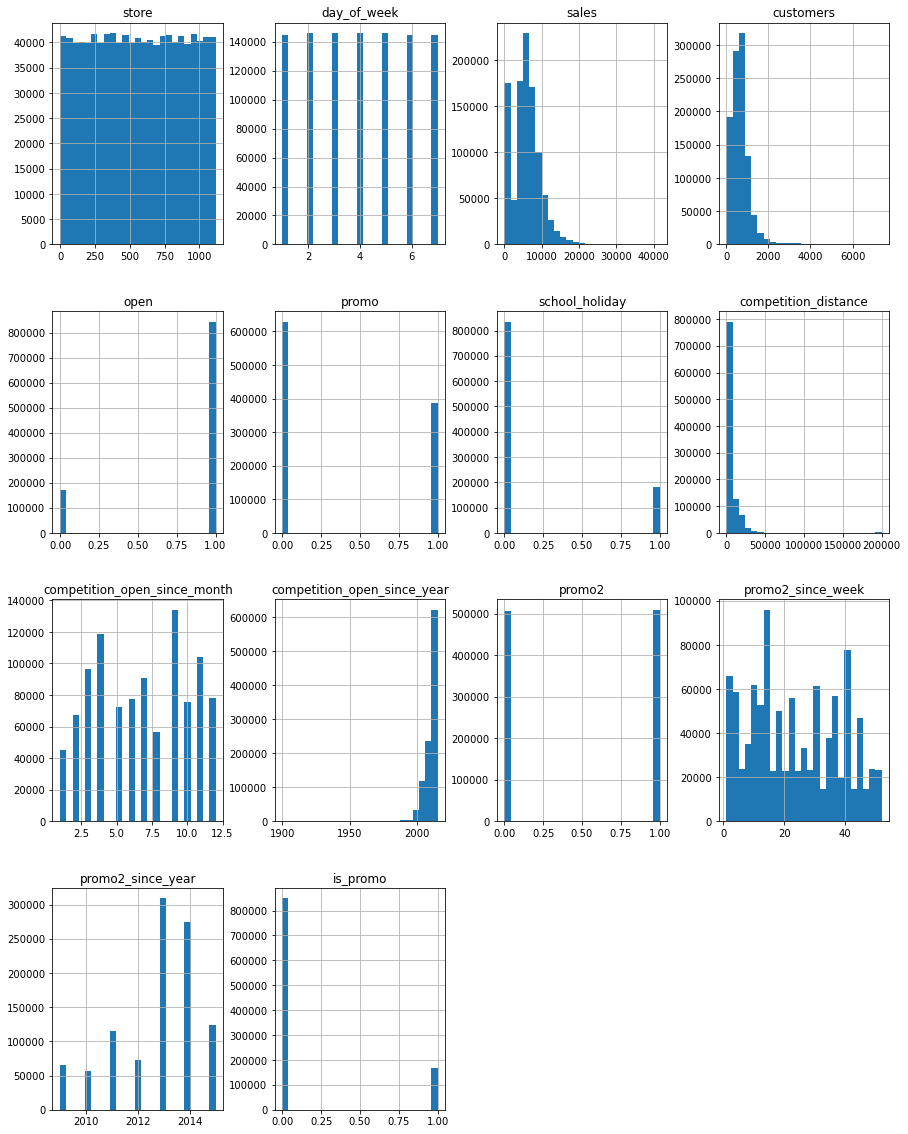

In [26]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
num_attributes.hist(bins = 25, ax = ax);

#### 4.1.3 Categorical Variable

In [27]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [28]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [29]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result 

<AxesSubplot:xlabel='sales', ylabel='Density'>

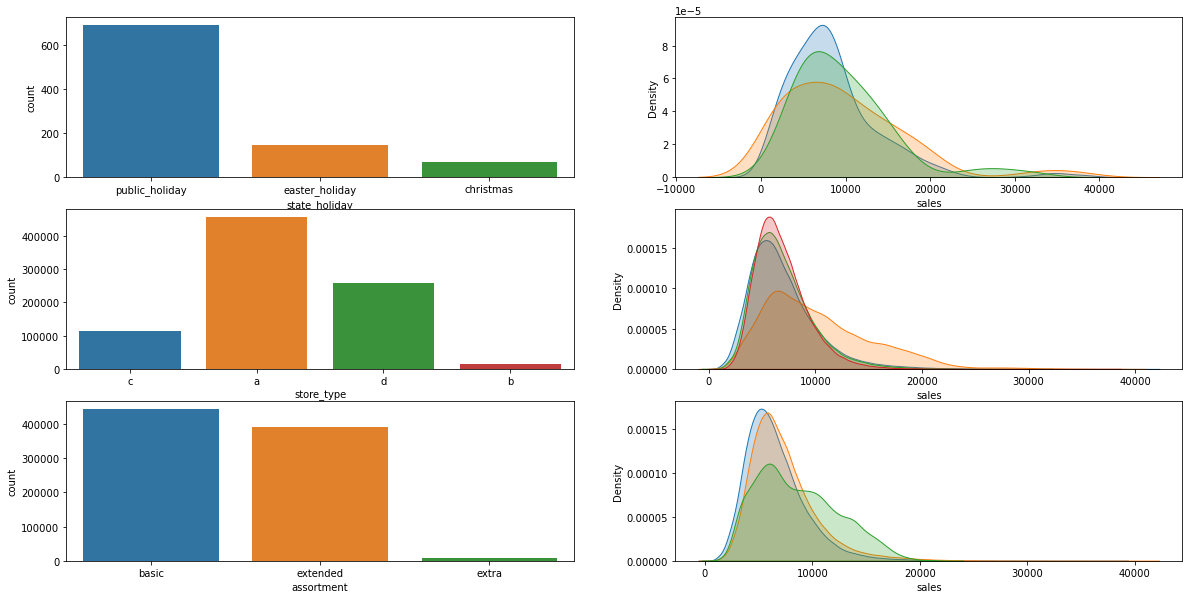

In [30]:
plt.rcParams['figure.figsize'] = (20, 10)
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


### 4.2 Bivariate Analysis

#### 1- Stores with a broader product assortment should sell more.

FALSE - Stores with a broader product assortment (EXTRA) sell LESS.

<AxesSubplot:xlabel='year_week'>

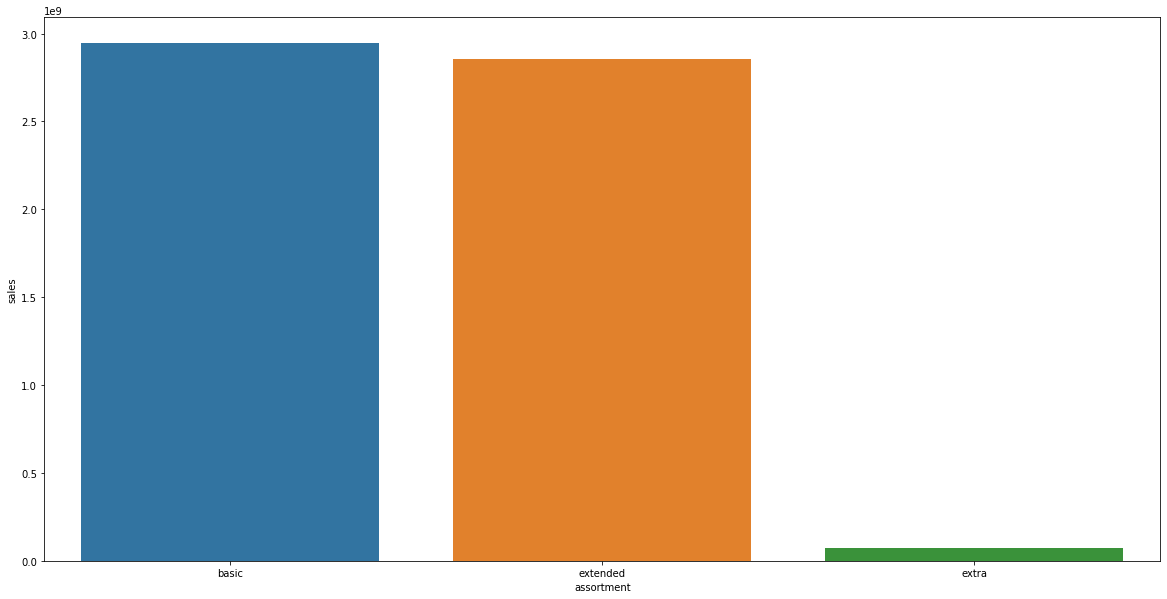

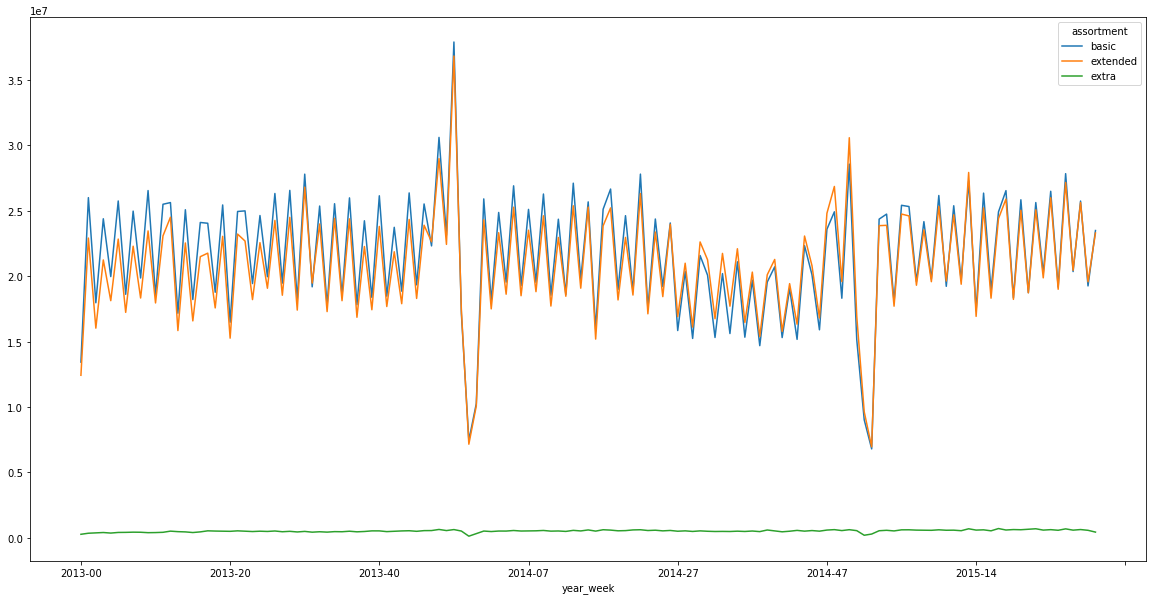

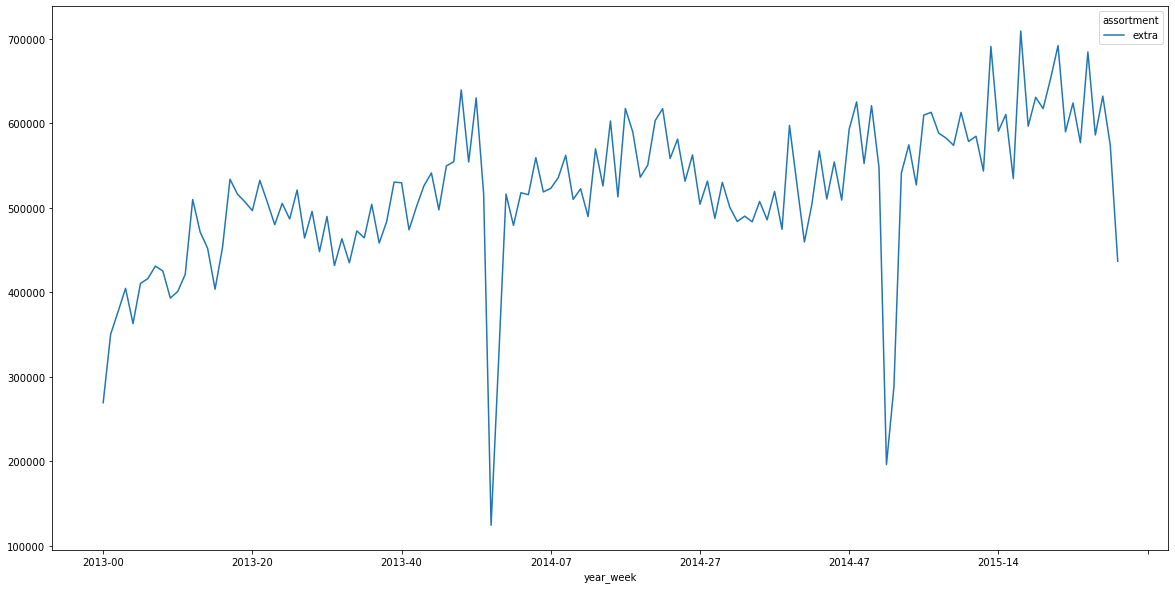

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

#### 2- Stores with a closer competition should sell less.

FALSE - Stores with a closer competition sell MORE.

<AxesSubplot:>

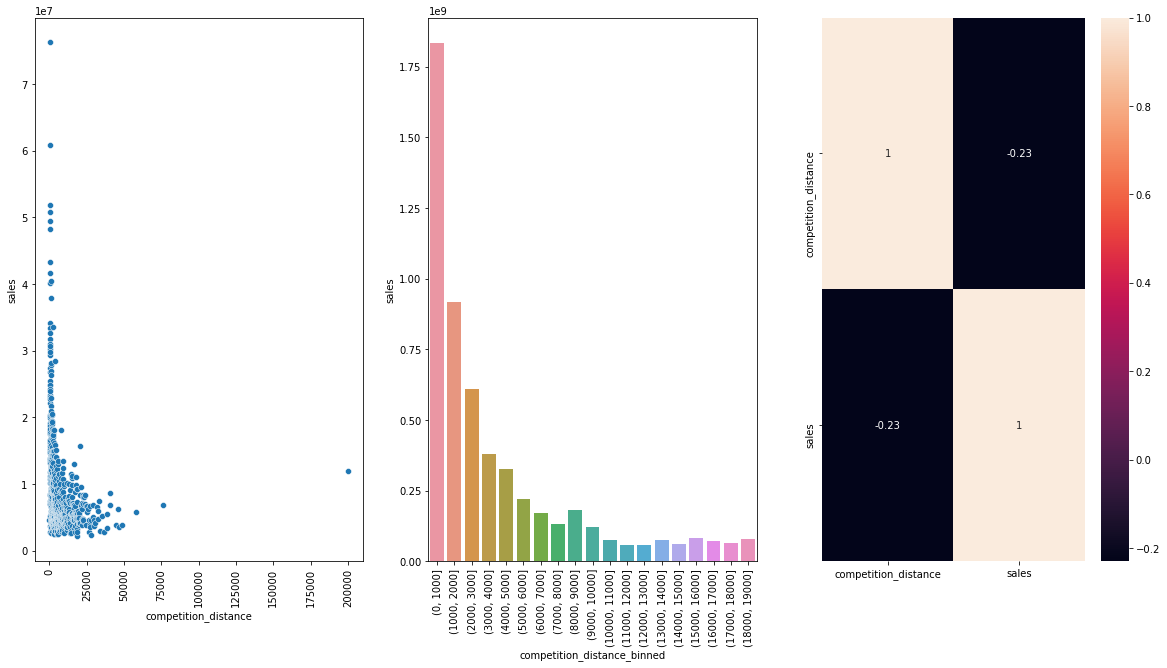

In [32]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data= aux1)
plt.xticks(rotation = 90)

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)

aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data= aux2)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)



#### 3- Stores with a closer competition for longer period should sell more.

FALSE - Stores with a closer competition for longer period should sell LESS.

<AxesSubplot:>

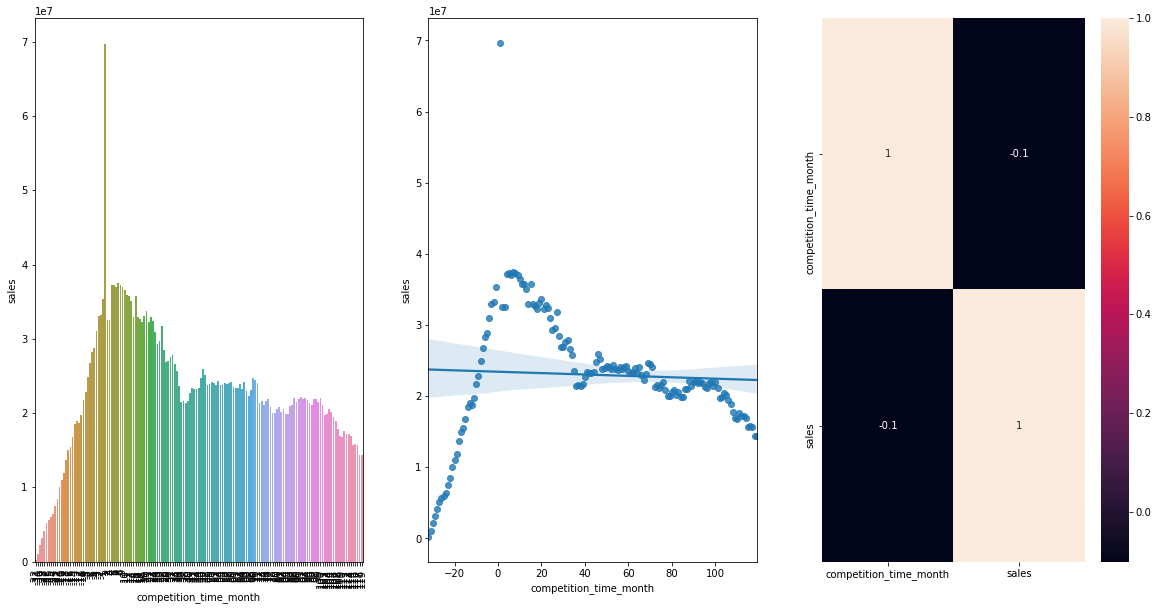

In [33]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.subplot(1, 3, 1)
sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2);
plt.xticks(rotation = 90);
plt.subplot(1, 3, 2)
sns.regplot(x= 'competition_time_month', y= 'sales', data= aux2)
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)

#### 4- Stores with longer active sales campaigns should sell more.

FALSE - Stores with longer active sales campaigns sell LESS after a certain sales period.

<AxesSubplot:>

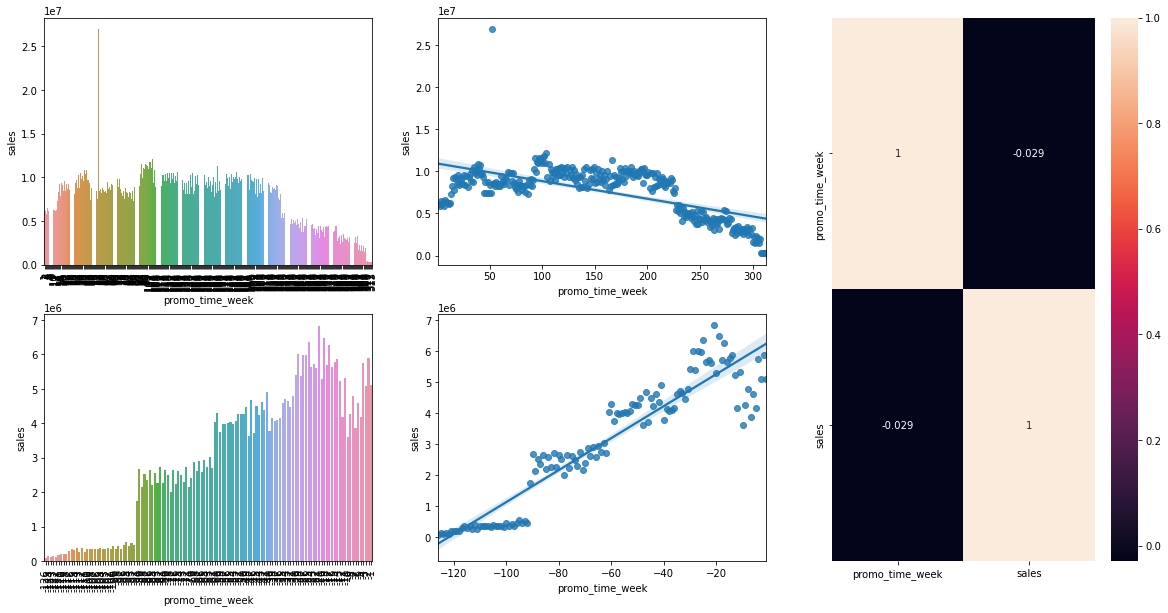

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3) 

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo sales
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2)
plt.xticks(rotation = 90)

plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo sales
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3)
plt.xticks(rotation = 90)

plt.subplot(grid[1,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

#### 5- <s>Stores with higher number of sales campaigns should sell more.</s>

#### 6- Stores with consecutive sales campaigns should sell more.

FALSE - Stores with consecutive sales campaigns sell LESS.

In [35]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


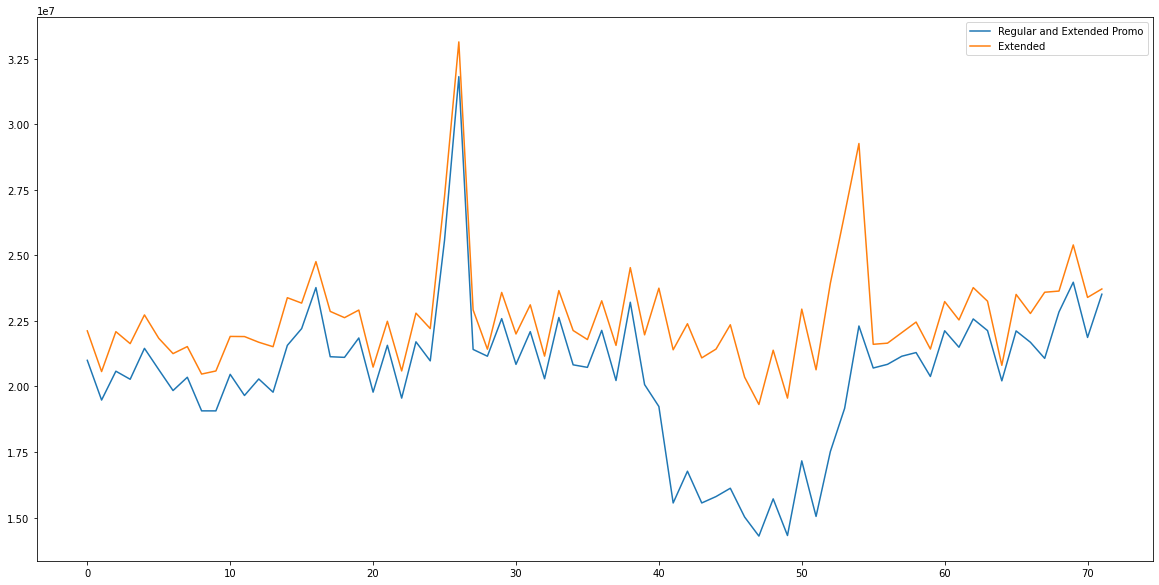

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend(labels=['Regular and Extended Promo', 'Extended'])

#### 7- Stores open during christmas holidays should have more sales.

FALSE - Stores open during christmas holidays have LESS sales.

<AxesSubplot:xlabel='Year', ylabel='sales'>

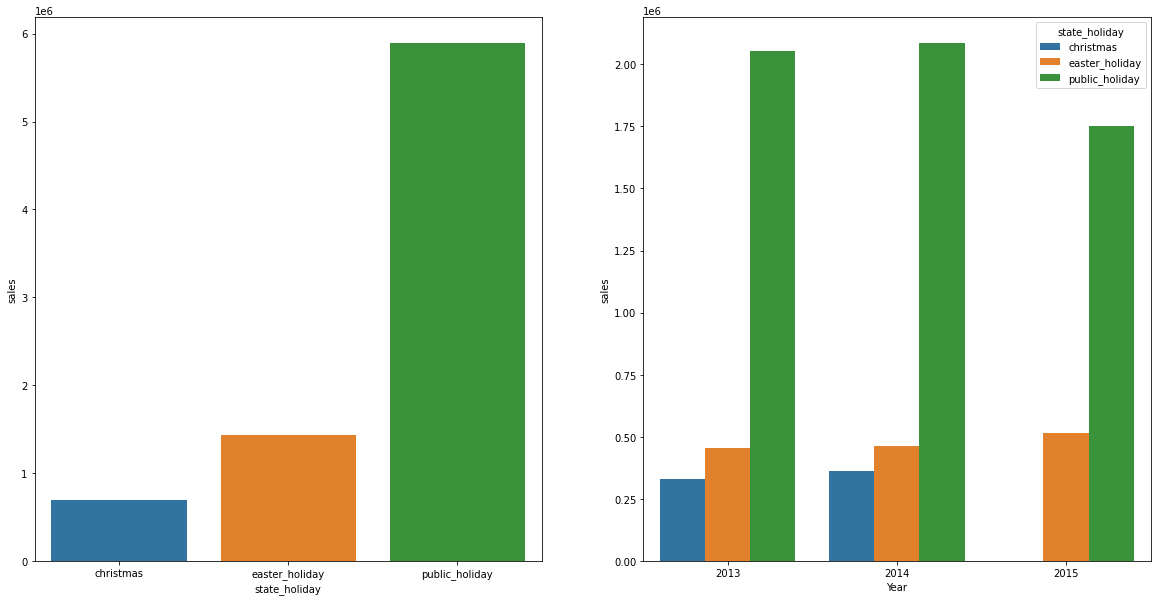

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x= 'state_holiday', y='sales', data= aux1)

aux2 = aux[['Year', 'state_holiday', 'sales']].groupby(['Year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x= 'Year', y='sales', hue= 'state_holiday', data= aux2)

#### 8- Stores should sell more along the years.

FALSE - Stores sell LESS along the years.

<AxesSubplot:>

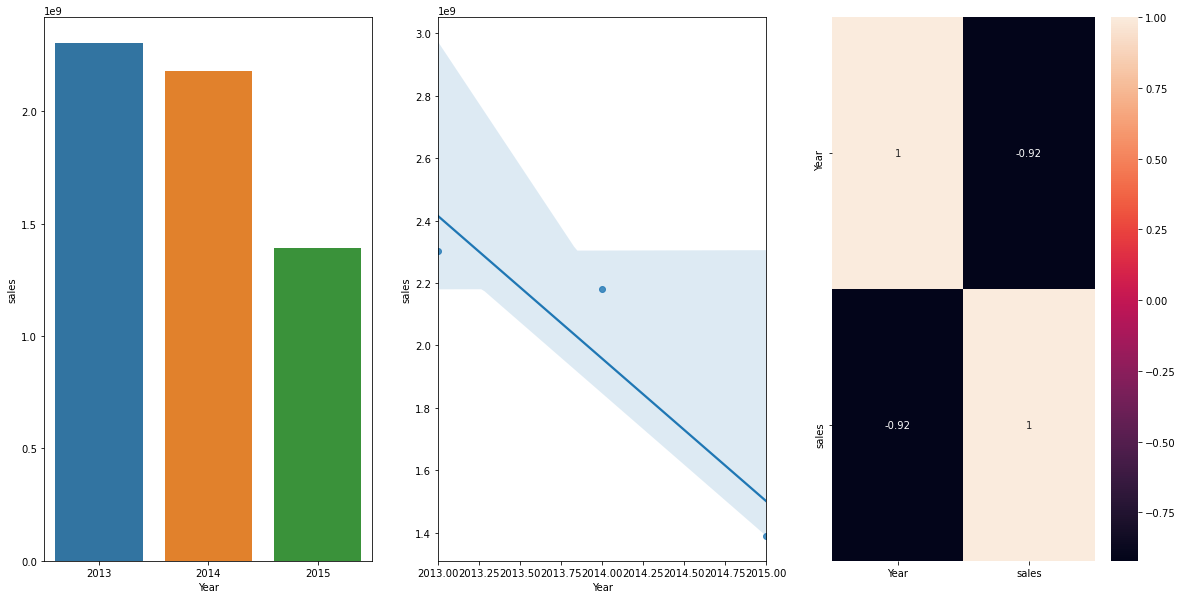

In [38]:
aux1 = df4[['Year', 'sales']].groupby("Year").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='Year', y='sales', data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='Year', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

#### 9- Stores should sell more on the second semester of years.

FALSE - Stores sell LESS on the second semester of years

<AxesSubplot:>

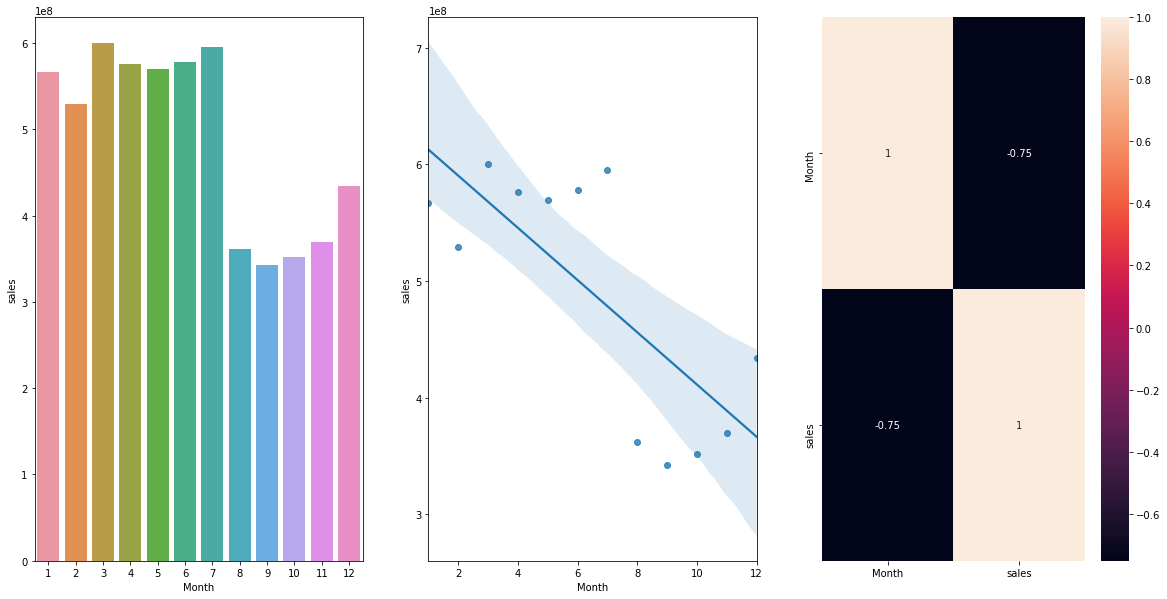

In [39]:
aux1 = df4[['Month', 'sales']].groupby("Month").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='Month', y='sales', data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='Month', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

#### 10- Stores should sell more after the 10th day of each month.

TRUE - Stores sell MORE after the 10th of each month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

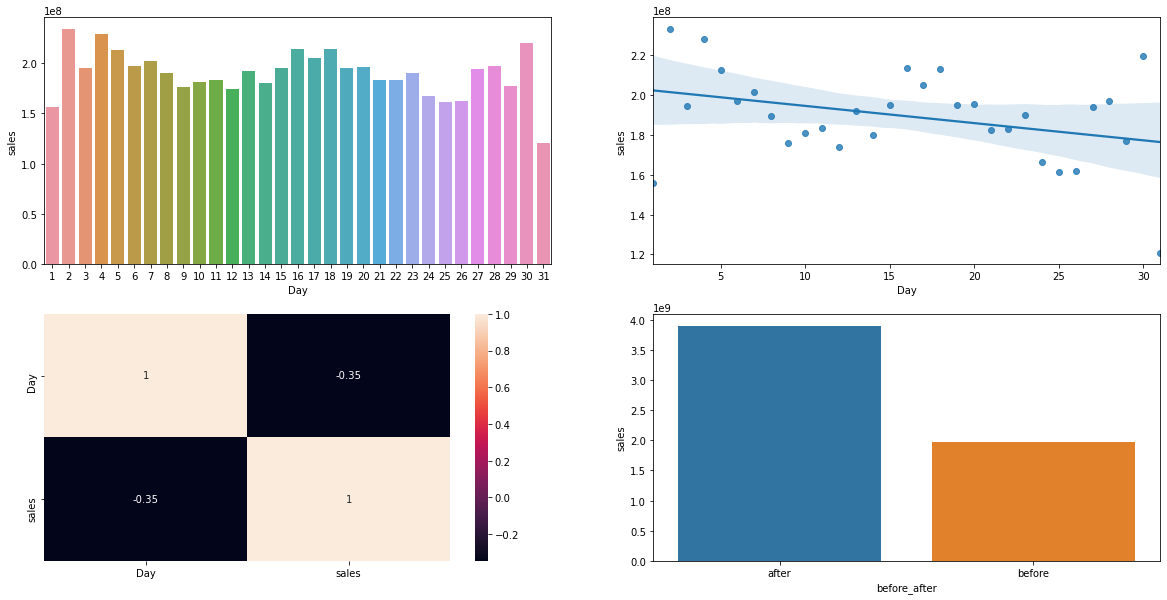

In [40]:
aux1 = df4[['Day', 'sales']].groupby("Day").sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='Day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='Day', y='sales', data=aux1);

plt.subplot(2,2,3);
sns.heatmap(aux1.corr(method='pearson'), annot = True)

aux1['before_after'] = aux1['Day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4);
sns.barplot(x= 'before_after', y= 'sales', data=aux2)

#### 11- Stores should sell less on weekends.

TRUE - Stores SELL less on weekends.

<AxesSubplot:>

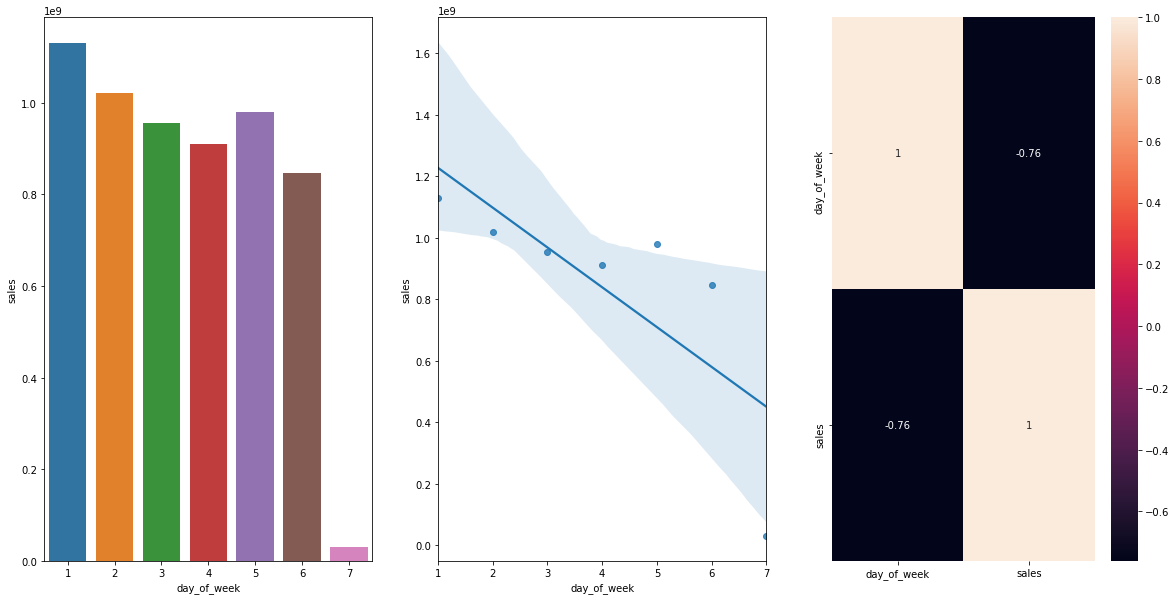

In [41]:
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'day_of_week', y= 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x= 'day_of_week', y= 'sales', data= aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

#### 12- Stores should sell less during scholar holiday

TRUE - Stores SELL less during scholar holiday, except on August.

<AxesSubplot:xlabel='Month', ylabel='sales'>

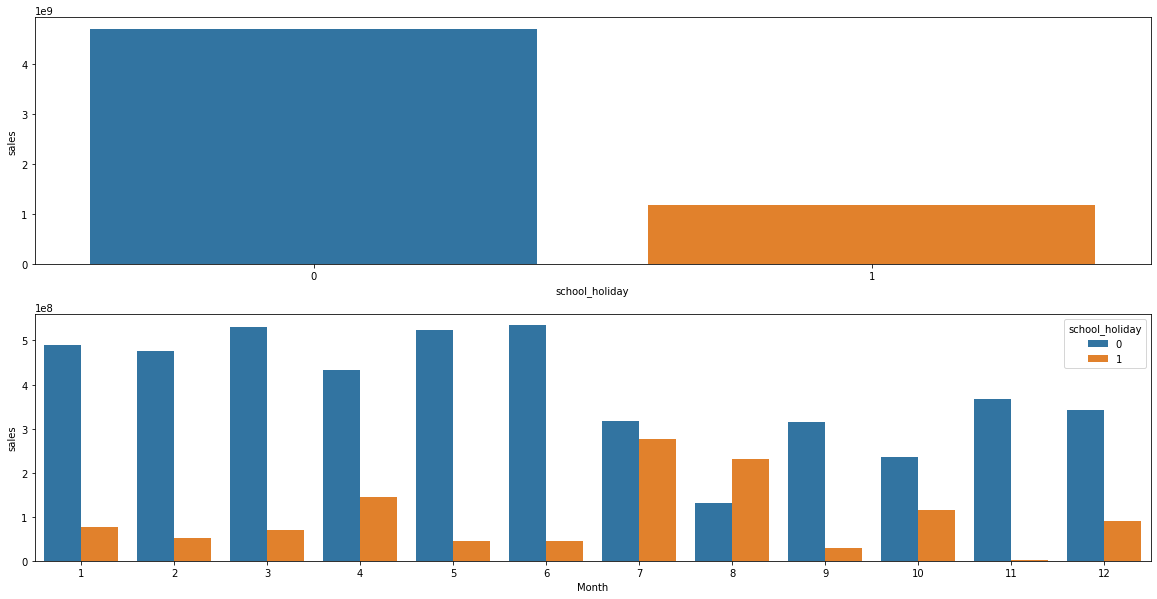

In [42]:
aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x= 'school_holiday', y= 'sales', data= aux1)

aux2= df4[['Month', 'school_holiday', 'sales']].groupby(['school_holiday', 'Month']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x= 'Month', y= 'sales', hue= 'school_holiday', data= aux2)

### 4.3 Multivariate Analysis

#### 4.3.1 Numerical Attributes

<AxesSubplot:>

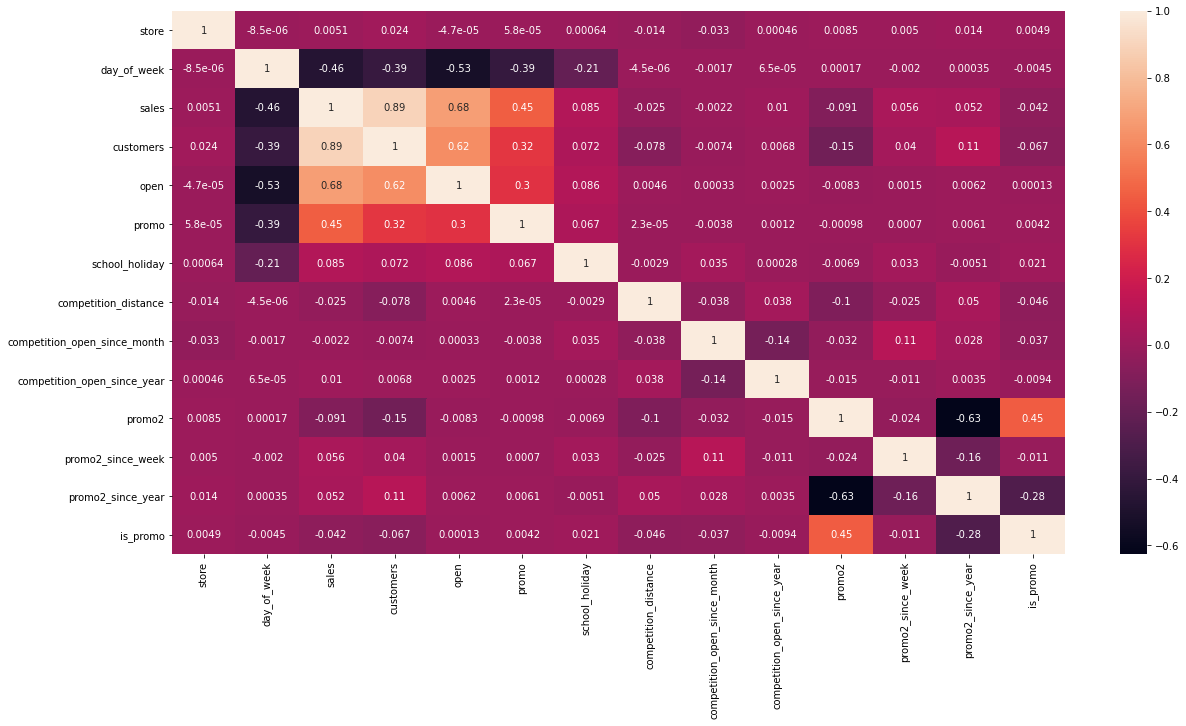

In [43]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot= True)

#### 4.3.1 Categorical Attributes

In [44]:
#filtering categorical columns
a = df4[['state_holiday', 'store_type', 'assortment']]
a.head(5)

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


In [45]:
#cramer V function with biased correction
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n= cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / (min (kcorr-1, rcorr-1)))

<AxesSubplot:>

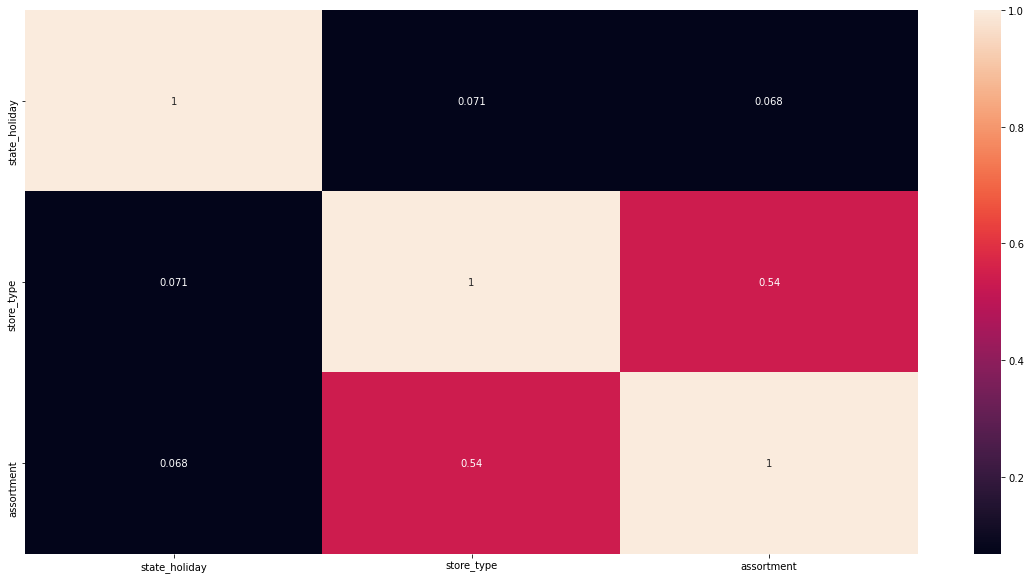

In [46]:
#Cramer V Calculations
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#V-cramer correlation dataframe
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [47]:
df5 = df4.copy()

### 5.1 Normalization

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


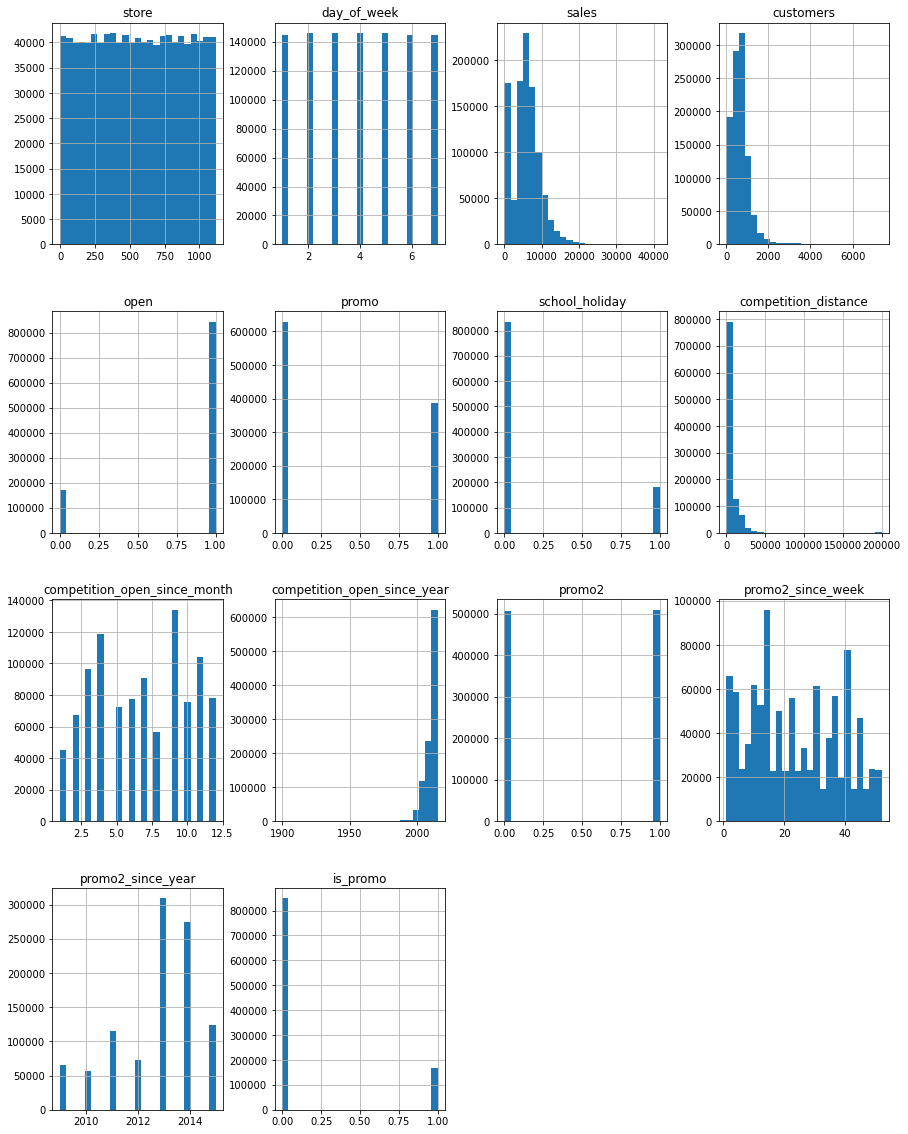

In [48]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
num_attributes.hist(bins = 25, ax = ax);

### 5.2 Rescaling

In [49]:
df5.select_dtypes(include = ['int64', 'float64'])
df5.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,Year,Month,Day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [50]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['competition_time_month']].values)
#year
df5['Year'] = mms.fit_transform(df5[['Year']].values)

### 5.3 Transformation

#### 5.3.1 Encoding

In [51]:
#state_holiday - ONE HOT ENCODING(DUMMY)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=["state_holiday"])

#store type - LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - ORDINAL ENCODING
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Responsive Variable Transformation

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

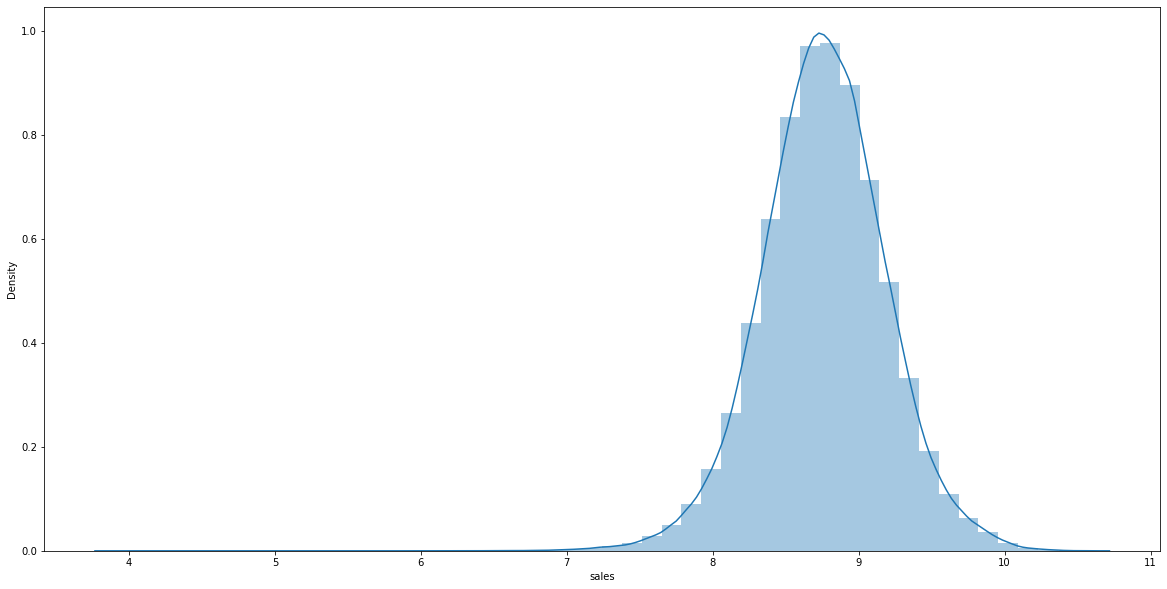

In [52]:
df5['sales'] = np.log1p(df5['sales'])

sns.distplot(df5['sales'])

#### 5.3.3 Nature Transformation

In [53]:
#month
df5['month_sin'] = df5['Month'].apply(lambda x: np.sin (x* (2. * np.pi/12)))
df5['month_cos'] = df5['Month'].apply(lambda x: np.cos (x* (2. * np.pi/12)))
#day
df5['day_sin'] = df5['Day'].apply(lambda x: np.sin (x* (2. * np.pi/30)))
df5['day_cos'] = df5['Day'].apply(lambda x: np.cos (x* (2. * np.pi/30)))
#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x* (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x* (2. * np.pi/52)))
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x* (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x* (2. * np.pi/7)))

# 6.0 Feature Selection

In [54]:
df6 = df5.copy()

In [55]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval', 'month_map',
       'is_promo', 'Year', 'Month', 'Day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin',
       'day_of_week_cos'],
      dtype='object')

### 6.1 Split Dataframe into training and test dataset

In [56]:
cols_drop = ['week_of_year', 'Day', 'Month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'promo_interval', 'month_map', 'customers', 'open']
df6 = df6.drop(cols_drop, axis =1)

In [57]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [58]:
#TRAINING DATASET
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#TEST DATASET
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

### 6.2 Boruta Algorithm as Feature Selector

In [59]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [60]:
#define training and test dataset for Boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()
#define random forest regressor
rf = RandomForestRegressor(n_jobs=-1)
#define boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


#### 6.2.1 Best Features from Boruta

In [61]:
cols_selected = boruta.support_.tolist()
#Best Features Boruta
x_train_fs = x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#Not Selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [62]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [63]:
cols_not_selected_boruta

['Year',
 'is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin']

### 6.2 Combining Boruta Selected with Manual Picked Features

In [114]:
#Features checkpoint
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance', 
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2', 
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month', 
                        'promo_time_week', 
                        'day_of_week_sin', 
                        'day_of_week_cos', 
                        'month_sin',
                        'month_cos',
                        'day_sin', 
                        'day_cos', 
                        'week_of_year_sin', 
                        'week_of_year_cos']
#columns to re-add
feat_to_add = ['date', 'sales']

#final features

cols_selected_boruta_full = ['store','promo','store_type',  'assortment', 'competition_distance',  'competition_open_since_month', 
                        'competition_open_since_year',  'promo2',  'promo2_since_week',  'promo2_since_year', 
                        'competition_time_month',  'promo_time_week', 'day_of_week_sin',  'day_of_week_cos',  'month_sin',
                        'month_cos', 'day_sin',  'day_cos',  'week_of_year_sin', 'week_of_year_cos', 'date', 'sales']

# 7.0 Machine Learning Modelling

In [65]:
x_train = x_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]

### 7.1 Average Model

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [67]:
def mean_absolute_percentage_error (y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'mae': mae,
                          'mape': mape,
                          'rmse': rmse}, index = [0])

In [68]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how= 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance 

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,mae,mape,rmse
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2 Linear Regression Model

In [69]:
from sklearn.linear_model import LinearRegression, Lasso

In [70]:
#model
lr = LinearRegression().fit(x_train, y_train)
#prediction
yhat_lr = lr.predict(x_test)
#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr)) 
lr_result

,Model Name,mae,mape,rmse
0,Linear Regression,1867.325182,0.292692,2671.685987


### 7.3 Linear Regression Regularized Model - Lasso

In [71]:
#model
lrr = Lasso(alpha = 0.0001).fit(x_train, y_train)
#prediction
yhat_lrr = lrr.predict(x_test)
#performance
lrr_result = ml_error('Linear Regression-Lasso', np.expm1(y_test), np.expm1(yhat_lrr)) 
lrr_result

,Model Name,mae,mape,rmse
0,Linear Regression-Lasso,1868.028625,0.292023,2675.723015


### 7.4 Random Forest Regressor

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance 
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,mae,mape,rmse
0,Random Forest Regressor,684.455116,0.10017,1020.659288


### 7.5 XGBoost Regressor

In [74]:
import xgboost as xgb

In [75]:
#model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytee = 0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[16:53:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,mae,mape,rmse
0,XGBoost Regressor,6684.250045,0.949627,7331.194137


### 7.6 Models Performance Comparison

In [76]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('rmse')

,Model Name,mae,mape,rmse
0,Random Forest Regressor,684.455116,0.100170,1020.659288
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.325182,0.292692,2671.685987
0,Linear Regression-Lasso,1868.028625,0.292023,2675.723015
0,XGBoost Regressor,6684.250045,0.949627,7331.194137


In [133]:
x_training = df6[cols_selected_boruta_full]
x_training = x_training[x_training['date'] < '2015-06-19'] #6 weeks test re-excluded for validation

In [134]:
x_training.date.max() - datetime.timedelta(1*6*7)
x_training.date.max() - datetime.timedelta(0*6*7)

Timestamp('2015-06-18 00:00:00')

# 8.0 Hyperparameter Fine Tuning

In [113]:
cols_full

In [107]:
feat_to_add

['date', 'sales']

In [ ]:
oi =